# Reconstructing a spherically symmetric model
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units

from p3droslo.utils       import convert_angular_to_spatial, get_molar_mass
from p3droslo.object      import AstroObject
from p3droslo.observation import DataCube

from p3droslo.model import TensorModel
from p3droslo.utils import interpolate

In [2]:
import magritte.tools as tools

In [3]:
obj = AstroObject('IK Tau')

Using the parallax distance.


In [4]:
file = '/STER/frederikd/Deprojection/data/observations/IKTau_CO3-2.fits'
dat  = DataCube(file)

In [5]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=30, description='f', max=60), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [6]:
# Integrate over each channel map
I = np.sum(dat.img.astype(np.float64), axis=(1,2))

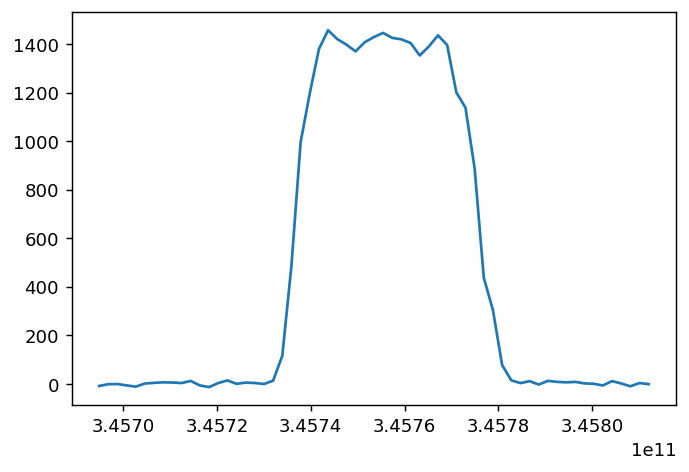

In [7]:
plt.figure(dpi=130)
plt.plot(dat.fs, I)

In [8]:
angle_x = abs(dat.npix_x * dat.pixsize_x)
angle_y = abs(dat.npix_y * dat.pixsize_y)

size_x = convert_angular_to_spatial(angle_x, obj.distance)
size_y = convert_angular_to_spatial(angle_y, obj.distance)
size_z = max(size_x, size_y)

size_x = size_x.to(units.m).value
size_y = size_y.to(units.m).value
size_z = size_z.to(units.m).value

shape = (128, 128, 128)

In [9]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim      import Adam, LBFGS

In [10]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [11]:
obs = I     .astype(np.float64)
fqs = dat.fs.astype(np.float64)

obs = torch.from_numpy(obs)
fqs = torch.from_numpy(fqs)

obs = obs[15:49]
fqs = fqs[15:49]

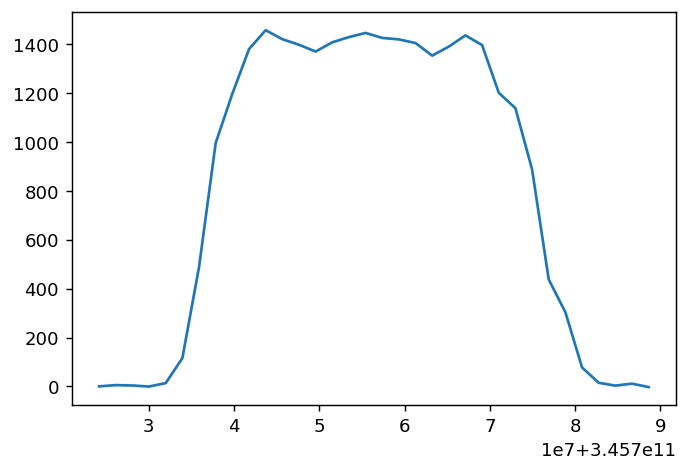

In [12]:
plt.figure(dpi=130)
plt.plot(fqs, obs)

In [13]:
def doppler_shift(velo):
    return 1.0 + velo/CC

In [14]:
def print_var(name, var):
    print(f"{name} {var.min().item():+1.2e} {var.mean().item():+1.2e} {var.max().item():+1.2e}")

In [15]:
from p3droslo.lines import LineData


import torch
import numpy as np

from astropy import constants


# Constants
CC  = constants.c  .si.value   # Speed of light [m/s]
HH  = constants.h  .si.value   # Planck's constant [J s]
KB  = constants.k_B.si.value   # Boltzmann's constant [J/K]
AMU = constants.u  .si.value   # Atomic mass unit [kg]


class Line:
    
    def __init__(self, species_name, transition, database='LAMDA', datafile=None):
        """
        Constructor for a line object.
        """
        # Store the name of the species
        self.species_name = species_name
        # Determine the molar mass of the species
        self.species_molar_mass = get_molar_mass(self.species_name)
        # Store the transition number
        self.transition = transition
        # Extract the line data
        self.linedata = LineData(database=database, datafile=datafile, species_name=species_name.lower())
        
        self.upper       = self.linedata.upper       [self.transition]
        self.lower       = self.linedata.lower       [self.transition]
        self.frequency   = self.linedata.frequency   [self.transition]
        self.Einstein_A  = self.linedata.Einstein_A  [self.transition]
        self.Einstein_Bs = self.linedata.Einstein_Bs [self.transition]
        self.Einstein_Ba = self.linedata.Einstein_Ba [self.transition]
        
        self.J_upper = self.linedata.J[self.upper]
        self.J_lower = self.linedata.J[self.lower]
        
        self.energy = torch.from_numpy(self.linedata.energy)
        self.weight = torch.from_numpy(self.linedata.weight)
        
        print(f"You have selected line:")
        print(f"    {self.species_name}(J={self.J_upper}-{self.J_lower})")
        print(f"Please check the properties that were inferred:")
        print(f"    {'Frequency '       :<17} {self.frequency :0.9e}  Hz")
        print(f"    {'Einstein A coeff ':<17} {self.Einstein_A:0.9e}  1/s")
        print(f"    {'Molar mass'       :<17} {self.species_molar_mass:<15}  g/mol")
        
        
    def gaussian_width(self, temperature, v_turbulence):
        """
        Gaussian spectral line width.
        """
        # Compute convenience variables
        factor_1 = self.frequency / CC
        factor_2 = 2.0 * KB / (self.species_molar_mass * AMU)
        # Return the gaussian line width
        return factor_1 * torch.sqrt(factor_2*temperature + v_turbulence**2)


    def gaussian_profile(self, temperature, v_turbulence, freq):
        """
        Gaussian spectral line profile function.
        """
        # Compute convenience variables
        inverse_width = 1.0 / self.gaussian_width(temperature, v_turbulence)
        factor        = 1.0 / np.sqrt(np.pi)
        # Mind the cellwise products
        shift  = torch.einsum("..., ...f -> ...f",          inverse_width, freq-self.frequency)
        result = torch.einsum("..., ...f -> ...f", factor * inverse_width, torch.exp(-shift**2))
        # Return the gaussian line profile
        return result

    
    def LTE_pops (self, temperature):
        """
        LTE level populations for the given temperature.
    
        Parameters
        ----------
        temperature : torch.Tensor
            Temperature for which to evaluate the LTE level populations.
    
        Returns
        -------
        out : array_like
            Array containing the LTE level populations for the given temperature.
        """
        exponent = torch.einsum("i   ,  ... -> i...", -self.energy/KB, 1.0/temperature) 
        pop      = torch.einsum("i   , i... -> i...",  self.weight,    torch.exp(exponent))
        pop      = torch.einsum("i...,  ... -> i...",  pop,            1.0/torch.sum(pop, dim=0))
        # Return result
        return pop
    
    
    def LTE_emissivity_and_opacity(self, temperature):
        """
        Line emissivity and opacity assuming LTE.
        
        Parameters
        ----------
        temperature : torch.Tensor
            Temperature for which to evaluate the LTE level populations.
    
        Returns
        -------
        eta, chi : torch.Tensor, torch.Tensor
            Tensor containing the LTE emissivities and opacities for the given temperature.
        """
        # Compute the prefactor
        factor = HH * self.frequency / (4.0 * np.pi)
        # factor = self.frequency * 1.0e-9
        
        # Compute the LTE level populations
        pop = self.LTE_pops(temperature)
        
        # Compute the emissivity and opacity
        eta = factor *  self.Einstein_A  * pop[self.upper]
        chi = factor * (self.Einstein_Ba * pop[self.lower] - self.Einstein_Bs * pop[self.upper]) 
        
        # print_var("factor", factor)
        # print_var("pop   ", pop)
        
        # Return results
        return (eta, chi)

In [16]:
line = Line('CO', 2)

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [17]:
def imaging_pipeline(model):
    
    # Compute the Doppler shift for each cell
    shift = 1.0 + model["velocity_z"]/CC
    
    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, fqs)

    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(model['temperature'])
    profile  = line.gaussian_profile          (model['temperature'], v_turb, freqs)

    print_var("eta", eta)
    print_var("chi", chi)
    print_var("pro", profile)
    
    eta = torch.einsum("..., ...f -> ...f", eta*model['CO'], profile)
    chi = torch.einsum("..., ...f -> ...f", chi*model['CO'], profile)
    
    # Create an image of the line
    img = model.create_image(eta, chi, axis=2)
    
    # Convolve with beam
    # img = convolve_with_beam(img)
    
    # Resolved out flux
    # img = resolved_out_flux(img)

    # Return the image
    return img

In [18]:
from torch.nn import functional

# def loss_function():
    # return functional.mse_loss(img, obs[0])

In [19]:
def haar_1D(a):
    wav = []
    avg = []
    while len(a) > 1:
        w = 0.5*(a[0::2] - a[1::2])
        a = 0.5*(a[0::2] + a[1::2])
        wav.append(w)
        avg.append(a)
    return avg, wav


def haar_loss_1(loss, a):
    
    avg, wav = haar_1D(a)
    for w in wav:
        loss += nn.functional.mse_loss(w, torch.zeros_like(w))
    return loss


def haar_loss(a):
    loss = torch.zeros(1)
    while len(a) > 1:
        loss += nn.functional.mse_loss(a[0::2], a[1::2])
        a = 0.5*(a[0::2] + a[1::2])
    return loss

In [20]:
a = torch.rand(2**16)

loss = torch.zeros(1)
loss

tensor([0.])

In [21]:
haar_loss_1(loss, a)

tensor([0.0837])

In [23]:
haar_loss(a)

tensor([0.3349])

In [26]:
%timeit loss_now = haar_loss_1(loss, a)

1.37 ms ± 4.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%timeit loss_now = haar_loss(a)

1.18 ms ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [108]:
%timeit torch.abs(torch.fft.rfft(a))

1.84 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
centre = (65.5,66.5,64)


class SphericallySymmetric():
    """
    Spherically Symmetric model functionality.
    """
    
    def __init__(self, model_1D):
        
        # Check if the input model is in fact 1D
        if model_1D.dimension != 1:
            raise ValueError(f"Input model is not 1D. model_1D.dimension = {model_1D.dimension}.")
    
        # Define the underlying 1D and 2D models
        self.model_1D = model_1D
        self.model_2D = TensorModel(
            sizes=(2*self.model_1D.sizes[0], self.model_1D.sizes[0]),
            shape=(2*self.model_1D.shape[0], self.model_1D.shape[0])
        )
        
        # Set origin for the 2D model halfway along the x axis
        origin_2D = np.array([0.5*(self.model_2D.shape[0]-1), 0.0])

        # Compute the radii in the 2D model
        rs_2D = self.model_2D.get_radius(origin=origin_2D)

        # Compute the 2D radii in the 1D model
        r = (self.model_1D.shape[0] / self.model_1D.sizes[0]) * rs_2D

        # Compute the corresponding indices of the 2D radii in the 1D model
        self.i_min = r.astype(np.int64)
        self.i_max = self.i_min + 1

        # Bound the indices from below
        self.i_min[self.i_min < 0] = 0
        self.i_max[self.i_max < 0] = 0

        # Bound the indices form above
        self.i_min[self.i_min >= self.model_1D.shape[0]] = self.model_1D.shape[0]-1
        self.i_max[self.i_max >= self.model_1D.shape[0]] = self.model_1D.shape[0]-1

        # Compute the scaling factor
        self.l = torch.from_numpy(r - self.i_min)
        
    def map_1D_to_2D(self, var):
            
        return self.l*var[self.i_max] + (1.0-self.l)*var[self.i_min]

    
    def map_variables(self, keys):
        
        for key in keys:
            self.model_2D[key] = self.map_1D_to_2D(self.model_1D[key])

            
    def get_los_projection(self):
            
        coords = self.model_2D.get_coords()
        radius = self.model_2D.get_radius()

        direction = (1.0 / radius) * coords
        
        return torch.from_numpy(direction[0])
    
    
    def get_circular_weights(self):
    
        coords = self.model_2D.get_coords()
        
        return torch.from_numpy(2.0*np.pi*coords[1,0])    

In [436]:
model_1D = TensorModel(
    sizes = (size_x,),
    shape = (128),
    keys  = ['log_CO', 'log_temperature', 'velocity']
)

v_turb = 5.0e+2 # m/s

# model_1D['log_velocity'] = torch.ones(model_1D.shape, dtype=torch.float64, requires_grad=True)
# model_1D['log_velocity'].data *= np.log(2.0e+4)

# model_1D['log_CO'] = torch.ones(model_1D.shape, dtype=torch.float64, requires_grad=True)
# model_1D['log_CO'].data *= np.log(1.0e+10)

# model_1D['log_temperature'] = torch.ones(model_1D.shape, dtype=torch.float64, requires_grad=True)
# model_1D['log_temperature'].data *= np.log(2.0e+2)


model_1D['log_velocity']    = torch.linspace(np.log(1.0e+2 ), np.log(3.5e+4), model_1D.shape[0], dtype=torch.float64, requires_grad=True)
model_1D['log_CO']          = torch.linspace(np.log(1.0e+19), np.log(1.0e-9), model_1D.shape[0], dtype=torch.float64, requires_grad=True)
model_1D['log_temperature'] = torch.linspace(np.log(1.0e+4),  np.log(2.5e+0), model_1D.shape[0], dtype=torch.float64, requires_grad=True)



spherical = SphericallySymmetric(model_1D)
spherical.map_variables(spherical.model_1D.keys())

model_1D  = spherical.model_1D
model_2D  = spherical.model_2D
direction = spherical.get_los_projection()
c_weights = spherical.get_circular_weights()

losses_rep = []
losses_reg = []

In [457]:
# width = line.gaussian_width(tmp[0,0], v_turb)
# frequencies = line.frequency + 10 * width.item() * torch.linspace(-1, +1, fqs.size(0))

# prof = line.gaussian_profile (tmp[0,0], v_turb, frequencies)

v_los = 34000

N_epochs = 100
lr       = 3.0e-2

optimizer = Adam(model_1D.parameters(), lr=lr)

In [458]:
def add_loss_continuity(loss, model):
    for key in model.keys():
        loss += nn.functional.mse_loss(model_1D[key][1:], model_1D[key][:-1])
    return loss

In [459]:
def haar_loss(a):
    loss = torch.zeros(1)
    while len(a) > 1:
        loss += nn.functional.mse_loss(a[0::2], a[1::2]) * len(a)
        a = 0.5*(a[0::2] + a[1::2])
    return loss

In [460]:
def fourier_loss(a):
    
    fft = torch.abs(torch.fft.rfft(a))
    
    size = fft.size(0)
    
    wts = 5*torch.arange(size)
    
    loss = nn.functional.mse_loss(fft*wts, torch.zeros(size, dtype=fft.dtype))
    
    return loss

100%|█████████████████████████████████████| 100/100 [00:02<00:00, 36.11it/s]


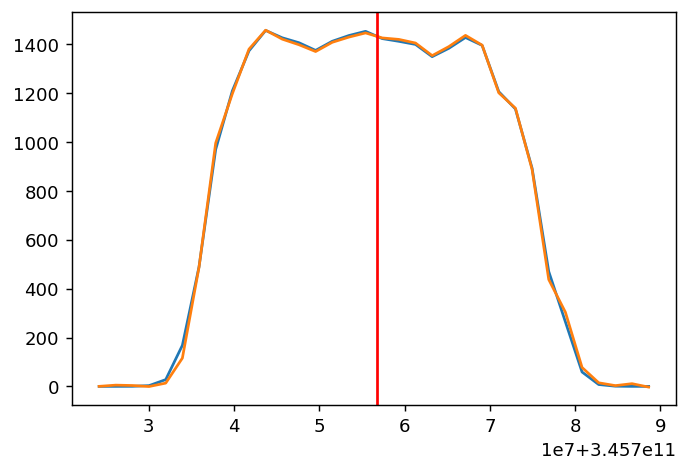

In [466]:
for _ in tqdm(range(N_epochs)):
    spherical.map_variables(spherical.model_1D.keys())

    model_1D  = spherical.model_1D
    model_2D  = spherical.model_2D

    tmp = torch.exp(model_2D['log_temperature'])
    nCO = torch.exp(model_2D['log_CO'])         
    vel = torch.exp(model_2D['log_velocity'])
    
    # print_var("tmp", tmp)
    # print_var("nCO", nCO)
    # print_var("vel", vel)
    
    # Compute the Doppler shift for each cell
    shift = 1.0 + (vel*direction + v_los) * (1.0 / CC)
    
    # frequencies = fqs * (1.0 + 34000 / CC)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, fqs)

    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(tmp)
    profile  = line.gaussian_profile          (tmp, v_turb, freqs)

    # print_var("pro", profile)
    
    eta = torch.einsum("..., ...f -> ...f", eta*nCO, profile)
    chi = torch.einsum("..., ...f -> ...f", chi*nCO, profile)
    
    # print_var("eta", eta)
    # print_var("chi", chi)
    
    # Create an image of the line
    img = model_2D.create_image(eta, chi, axis=0)
    
    
    I = torch.einsum("if,i -> f", img, c_weights)
    # I *= 0.25
    
    loss_rep = nn.functional.mse_loss(I, obs)
    loss_reg = model_1D.apply(fourier_loss)
    
    loss_func = loss_rep + 0.01*loss_reg
    
    # loss_func = add_loss_continuity(loss_func, model_1D)
             
    # break
    # print(img.min().item(), img.mean().item(), img.max().item())
    # print(obs.min().item(), obs.mean().item(), obs.max().item())
    
    losses_rep.append(loss_rep.item())
    losses_reg.append(loss_reg.item())
    
    optimizer.zero_grad()
    
    loss_func.backward ()
    optimizer.step     ()
    
plt.figure(dpi=130)
plt.plot(fqs, I.data)
plt.plot(fqs, obs.data)
# plt.plot(frequencies, prof.data)
# plt.axvline(line.frequency, c='k')

plt.axvline(line.frequency * (1.0 - 34000 / CC), c='r')
# plt.yscale('log')


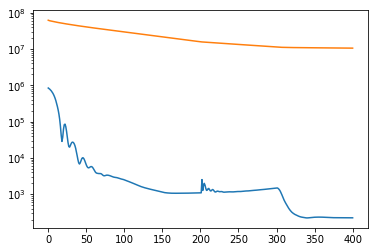

In [467]:
plt.plot(losses_rep)
plt.plot(losses_reg)
plt.yscale('log')

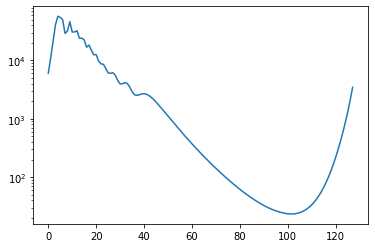

In [472]:
plt.plot(torch.exp(model_1D['log_temperature']).data)
plt.yscale('log')

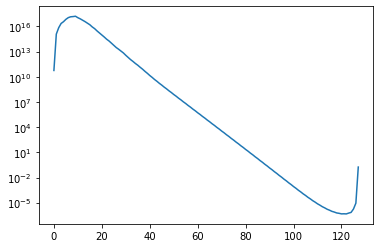

In [474]:
plt.plot(torch.exp(model_1D['log_CO']).data)
plt.yscale('log')

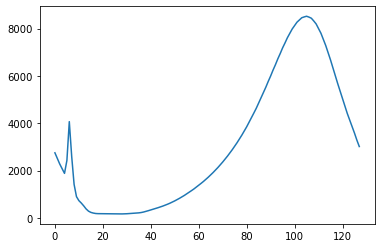

In [475]:
plt.plot(torch.exp(model_1D['log_velocity']).data)

In [259]:
class Data(Dataset):
    def __init__(self, datacube):
        self.datacube = datacube
    
    def __len__(self):
        return self.datacube.img.size

    def __getitem__(self, idx):
        return self.datacube.img[idx]